In [1]:
import numpy as np
import os
import glob
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


## All features for Emiliani2 with target Emiliani2 VHI

In [4]:
target_region = 'Emiliani2'
csv_with_aggreg = "./features_with_aggregations_" + target_region + ".csv"

In [5]:
all_features = pd.read_csv(csv_with_aggreg).rename(columns={'Unnamed: 0': 'date'})

In [6]:
# merge with target values of Emiliani2
csv_target = "./csv/Emiliani2.csv"
target = pd.read_csv(csv_target).rename(columns={'Unnamed: 0': 'date'})

# remove dates not available in features
target = target[target['date'] <= all_features['date'].iloc[-1]]

target_df = pd.merge(all_features, target, on=['date'])['mean'].to_frame()

In [7]:
# remove the date column
features_df = all_features.iloc[:,1:]

In [9]:
idx_dic = {}
for col in features_df.columns:
    idx_dic[col] = features_df.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_Emiliani2_tg
1: cyclostationary_mean_Emiliani2_rr
2: cyclostationary_mean_Emiliani2_tg_1w
3: cyclostationary_mean_Emiliani2_tg_4w
4: cyclostationary_mean_Emiliani2_tg_8w
5: cyclostationary_mean_Emiliani2_tg_12w
6: cyclostationary_mean_Emiliani2_tg_16w
7: cyclostationary_mean_Emiliani2_tg_24w
8: cyclostationary_mean_Emiliani2_rr_1w
9: cyclostationary_mean_Emiliani2_rr_4w
10: cyclostationary_mean_Emiliani2_rr_8w
11: cyclostationary_mean_Emiliani2_rr_12w
12: cyclostationary_mean_Emiliani2_rr_16w
13: cyclostationary_mean_Emiliani2_rr_24w


# Feature Selection and linear regression

### Prepare pickle file for FS algorithm, with only the training set

In [ ]:
# features selection done only on training set
n = 0.6

features_train = features_df.iloc[0:round(len(features_df)*n)]
len(features_train)

589

In [ ]:
target_train = target_df[0:round(len(target_df)*n)]
len(target_train)

589

In [ ]:
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features_train.values)
scaled_train_target = scaler.fit_transform(target_train.values)

In [ ]:
output = { "X" : scaled_train_features, "Y" : scaled_train_target}

with open("./pickles/targetEmiliani2.pickle", "wb") as f:
    pickle.dump(output, f)

### FS algorithm with different parameters values

#### k = 3

In [ ]:
# Delta: 0.005, 0.01, final number of features: 1, selected features IDs: [9]
# Delta: 0.03 final number of features: 3, selected features IDs: [9, 2]
# Delta: 0.05, 0.1 final number of features: 6, selected features IDs: [9, 2, 13]

%run "./scripts/main.py" --classification 0 --filename "./pickles/targetEmiliani2.pickle" --backward 'f' --k 3

#### k = 10

In [ ]:
# Delta: 0.005, 0.01, final number of features: 1, selected features IDs: [0]
# Delta: 0.03 final number of features: 3, selected features IDs: [0, 10, 7, 11]
# Delta: 0.05, 0.1 final number of features: 4, selected features IDs: [0, 10, 7, 11]

%run "./scripts/main.py" --classification 0 --filename "./pickles/targetEmiliani2.pickle" --backward 'f' --k 10

#### k = 25

In [ ]:
# Delta: 0.005, 0.01, final number of features: 1, selected features IDs: [0]
# Delta: 0.03, 0.05, 0.1 final number of features: 4, selected features IDs: [0, 10, 11, 2, 3, 9]

%run "./scripts/main.py" --classification 0 --filename "./pickles/targetEmiliani2.pickle" --backward 'f' --k 25

#### k = 100

In [ ]:
# Delta: 0.005, final number of features: 1, selected features IDs: [9]
# Delta: 0.01, 0.03, 0.05, 0.1 final number of features: 3, selected features IDs: [9, 0, 10]

%run "./scripts/main.py" --classification 0 --filename "./pickles/targetEmiliani2.pickle" --backward 'f' --k 100

## Linear Regression

In [10]:
# used split 80-20 for linear regression train and test

n = 0.8

# 785 samples
features_train_regr = features_df.iloc[0:round(len(features_df)*n),:]
target_train_regr = target_df.iloc[0:round(len(target_df)*n),:]

# 196 samples
features_test_regr = features_df.iloc[round(len(features_df)*n):]
target_test_regr = target_df.iloc[round(len(target_df)*n):]

scaler_f = StandardScaler()
scaler_t = StandardScaler()

# for training data fit and transform
scaled_train_features_regr = pd.DataFrame(scaler_f.fit_transform(features_train_regr.values), 
                               index=features_train_regr.index, columns=features_train_regr.columns)
scaled_train_target_regr = pd.DataFrame(scaler_t.fit_transform(target_train_regr.values), 
                             index=target_train_regr.index, columns=target_train_regr.columns)


scaled_test_features_regr = pd.DataFrame(scaler_f.transform(features_test_regr.values), 
                                    index=features_test_regr.index, columns=features_test_regr.columns)
scaled_test_target_regr = pd.DataFrame(scaler_t.transform(target_test_regr.values), 
                                    index=target_test_regr.index, columns=target_test_regr.columns)

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# tutte le features
X_train_all = scaled_train_features_regr
y_train_regr = scaled_train_target_regr

X_test_all = scaled_test_features_regr
y_test = scaled_test_target_regr

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
reg = LinearRegression().fit(X_train_all, y_train_regr)
print("Linear Regression all features: ")
print("R2_train: ", round(reg.score(X_train_all, y_train_regr),3))
#print(mean_squared_error(y_train,reg.predict(X_train_all),squared=False))
print("R2_test: ", round(reg.score(X_test_all, y_test),3))
print("MAE: ", round(mean_absolute_error(y_test,reg.predict(X_test_all)),3))
print("MSE: ", round(mean_squared_error(y_test,reg.predict(X_test_all),squared=False),3))
print('\n')

# delta piccolo
X_train = X_train_all.iloc[:,[9, 0]]
X_test = X_test_all.iloc[:,[9, 0]]
reg = LinearRegression().fit(X_train, y_train_regr)
print("R2_train: ", round(reg.score(X_train, y_train_regr),3))
print("R2_test: ", round(reg.score(X_test, y_test),3))
print("MSE: ", round(mean_squared_error(y_test,reg.predict(X_test),squared=False),3))
print('\n')

# delta grande, k piccola
print("Linear Regression chosen features: ")
X_train = X_train_all.iloc[:,[0, 10, 11, 2, 7, 9]]
X_test = X_test_all.iloc[:,[0, 10, 11, 2, 7, 9]]
reg = LinearRegression().fit(X_train, y_train_regr)
print("R2_train: ", round(reg.score(X_train, y_train_regr),3))
print("R2_test: ", round(reg.score(X_test, y_test),3))
print("MAE: ", round(mean_absolute_error(y_test,reg.predict(X_test)),3))
print("MSE: ", round(mean_squared_error(y_test,reg.predict(X_test),squared=False),3))
print('\n')

# delta medio, k alta
X_train = X_train_all.iloc[:,[0, 10, 7, 11]]
X_test = X_test_all.iloc[:,[0, 10, 7, 11]]
reg = LinearRegression().fit(X_train, y_train_regr)
print("R2_train: ", reg.score(X_train, y_train_regr))
print("R2_test: ", reg.score(X_test, y_test))
print("MSE: ", mean_squared_error(y_test,reg.predict(X_test),squared=False))
print('\n')

# delta alto, k alta
X_train = X_train_all.iloc[:,[9, 0, 10]]
X_test = X_test_all.iloc[:,[9, 0, 10]]
reg = LinearRegression().fit(X_train, y_train_regr)
print("R2_train: ", reg.score(X_train, y_train_regr))
print("R2_test: ", reg.score(X_test, y_test))
print("MSE: ", mean_squared_error(y_test,reg.predict(X_test),squared=False))

Linear Regression all features: 
R2_train:  0.236
R2_test:  0.107
MAE:  0.767
MSE:  0.949


R2_train:  0.203
R2_test:  0.089
MSE:  0.959


Linear Regression chosen features: 
R2_train:  0.226
R2_test:  0.113
MAE:  0.766
MSE:  0.946


R2_train:  0.21003714859155476
R2_test:  0.08381679559519217
MSE:  0.9615901378947136


R2_train:  0.2107910309733365
R2_test:  0.08957515434448426
MSE:  0.9585635003590819


In [ ]:
chosen_features_ids = [0, 10, 11, 2, 7, 9]
chosen_features = features_df.iloc[:,chosen_features_ids]

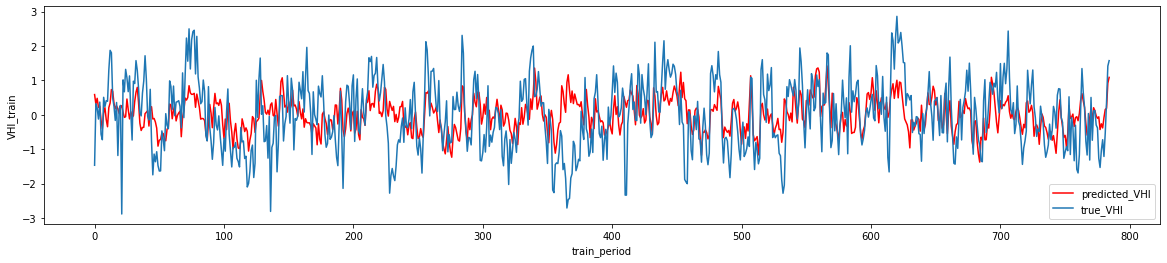

In [ ]:
import matplotlib.pyplot as plt

X_train = X_train_all.iloc[:,chosen_features_ids]
reg = LinearRegression().fit(X_train, y_train_regr)
# plot prediction on train
prediction = reg.predict(X_train)

plt.plot(prediction, color='red', label="predicted_VHI")
plt.plot(y_train_regr, label="true_VHI")

plt.ylabel("VHI_train")
plt.xlabel("train_period")

plt.legend(loc="lower right")

plt.rcParams["figure.figsize"] = (20,4)

plt.show()

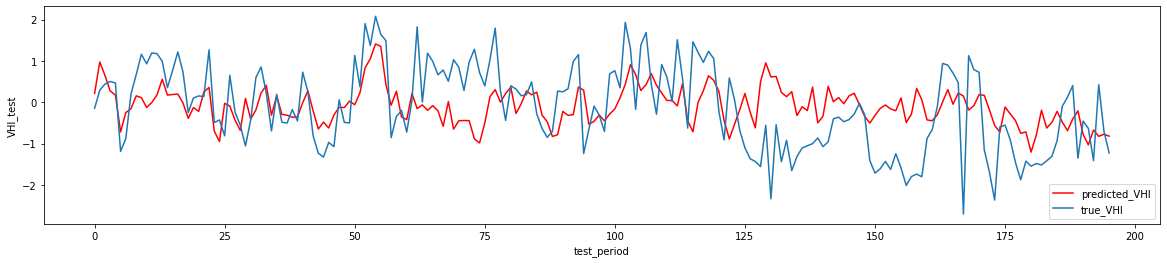

In [ ]:
X_test = X_test_all.iloc[:,chosen_features_ids]

prediction = reg.predict(X_test)

plt.plot(prediction, color='red', label="predicted_VHI")
y_test.reset_index(drop = True, inplace = True)
plt.plot(y_test, label="true_VHI")

plt.ylabel("VHI_test")
plt.xlabel("test_period")

plt.legend(loc="lower right")

plt.rcParams["figure.figsize"] = (15,4)
plt.show()

# Non linear models

## Imports and functions

In [16]:
! pip install tensorflow_addons
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow_addons.metrics import RSquare
from sklearn.model_selection import GridSearchCV

np.random.seed(1724)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.4 MB/s 


In [17]:
def feed_forward(num_units):
  # learning rate
  lr = 1e-3

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(units=num_units, activation=tf.keras.activations.relu))
  model.add(tf.keras.layers.Dense(units = 1))

  metrics = [tf.keras.metrics.MeanAbsoluteError()]

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
                loss='mse',
                metrics=metrics)
  
  return model

## With all features

In [18]:
# split: 20% for validation and 20% for test, 60% for train

train_perc = 0.6
valid_perc = 0.2
train_valid_perc = 1 - valid_perc
tot_rows = len(features_df)

features_train = features_df.iloc[0:round(tot_rows*train_perc),:]
target_train = target_df.iloc[0:round(tot_rows*train_perc),:]

scaler_f = StandardScaler()
scaler_t = StandardScaler()

# fit the scalers on training data
scaler_f.fit(features_train)
scaler_t.fit(target_train)

# scale all the dataset
features_df = pd.DataFrame(scaler_f.transform(features_df[features_df.columns]), 
                                    index=features_df.index, columns=features_df.columns)
target_df[target_df.columns] = scaler_t.transform(target_df[target_df.columns])

scaled_train_features = features_df.iloc[0:round(tot_rows*train_perc)]
scaled_valid_features = features_df.iloc[round(tot_rows*train_perc):round(tot_rows*train_valid_perc)]
scaled_test_features = features_df.iloc[round(tot_rows*train_valid_perc):]

scaled_train_target = target_df.iloc[0:round(tot_rows*train_perc)]
scaled_valid_target = target_df.iloc[round(tot_rows*train_perc):round(tot_rows*train_valid_perc)]
scaled_test_target = target_df.iloc[round(tot_rows*train_valid_perc):]

train_valid_features = pd.concat([scaled_train_features,scaled_valid_features]).values
train_valid_target = pd.concat([scaled_train_target,scaled_valid_target]).values

In [ ]:
print("Total numer of samples: ", len(features_df))
print("Train samples: ", len(scaled_train_features))
print("Validation samples and test samples: ", len(scaled_valid_features))
print("Training and validation samples: ", len(train_valid_features))

Total numer of samples:  981
Train samples:  589
Validation samples and test samples:  196
Training and validation samples:  785


### Extra Tree Regressor

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 120, num = 40)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
# bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              }

In [ ]:
ext = ExtraTreesRegressor(random_state=42)

opt = GridSearchCV(estimator=ext, param_grid = param_grid, verbose = 2)

# GridSearchCV already does 5-fold cross validation by default,
# so I take both train and validation data
opt.fit(train_valid_features.values, train_valid_target.values.ravel())

In [ ]:
opt.best_params_

{'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 117}

In [19]:
rfc= ExtraTreesRegressor(random_state=42, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, n_estimators = 117)

rfc.fit(train_valid_features, train_valid_target.ravel())

ExtraTreesRegressor(max_features='sqrt', min_samples_leaf=2, n_estimators=117,
                    random_state=42)

In [ ]:
rfc.score(scaled_test_features.values, scaled_test_target.values.ravel())

0.1978736293073453

In [21]:
rf_mae = mean_absolute_error(scaled_test_target.values.ravel(), rfc.predict(scaled_test_features.values))
rf_mse = mean_squared_error(scaled_test_target.values.ravel(), rfc.predict(scaled_test_features.values))
r2_test = rfc.score(scaled_test_features.values, scaled_test_target.values.ravel())
r2_train = rfc.score(train_valid_features, train_valid_target.ravel())
print(" ExtraTreesRegressor: ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","R2_test: ",
      round(r2_test,3), "\n", "R2_train: ", round(r2_train,3))

 ExtraTreesRegressor: 
 MAE:  0.729 
 MSE:  0.777 
 R2_test:  0.198 
 R2_train:  0.837


### FFNN

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

ffnn_val = feed_forward(4)

hist_val = ffnn_val.fit(scaled_train_features.values, scaled_train_target.values, shuffle=False, epochs=600, 
                        validation_data=(scaled_valid_features.values, scaled_valid_target.values), verbose = 0)

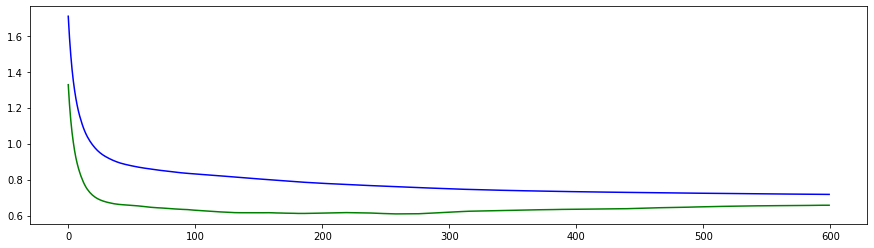

In [ ]:
plt.plot(hist_val.history['loss'], 'b')
plt.plot(hist_val.history['val_loss'],'g')

In [22]:
ffnn = feed_forward(4)
ffnn.fit(train_valid_features, train_valid_target, shuffle=False, epochs=120, verbose = 0)

In [23]:
ffnn_MAE = mean_absolute_error(scaled_test_target.values.ravel(), ffnn.predict(scaled_test_features.values))
ffnn_MSE = mean_squared_error(scaled_test_target.values.ravel(), ffnn.predict(scaled_test_features.values))

metric = RSquare()
metric.update_state(scaled_test_target.values, ffnn.predict(scaled_test_features.values))
r2_test = metric.result()
r2_test.numpy()

metric = RSquare()
metric.update_state(train_valid_target, ffnn.predict(train_valid_features))
r2_train = metric.result()
r2_train.numpy()

25/25 [==============================] - 0s 5ms/step


0.28973234

In [27]:
print(" FFNN: ")
print(" MAE: ", round(ffnn_MAE,3), "\n", "MSE: ", round(ffnn_MSE,3), "\n","R2_test: ",
      round(r2_test.numpy(),3), "\n", "R2_train: ", round(r2_train.numpy(),3))

 FFNN: 
 MAE:  0.759 
 MSE:  0.827 
 R2_test:  0.147 
 R2_train:  0.29


## With chosen features

In [28]:
chosen_features = features_df.iloc[:,[0, 10, 11, 2, 7, 9]]

train_perc = 0.6
valid_perc = 0.2
train_valid_perc = 1 - valid_perc
tot_rows = len(chosen_features)

features_train = chosen_features.iloc[0:round(tot_rows*train_perc),:]
target_train = target_df.iloc[0:round(tot_rows*train_perc),:]

scaler_f = StandardScaler()
scaler_t = StandardScaler()

# fit the scalers on training data
scaler_f.fit(features_train)
scaler_t.fit(target_train)

# scale all the dataset
chosen_features = pd.DataFrame(scaler_f.transform(chosen_features[chosen_features.columns]), 
                                    index=chosen_features.index, columns=chosen_features.columns)
target_df[target_df.columns] = scaler_t.transform(target_df[target_df.columns])

scaled_train_features = chosen_features.iloc[0:round(tot_rows*train_perc)]
scaled_valid_features = chosen_features.iloc[round(tot_rows*train_perc):round(tot_rows*train_valid_perc)]
scaled_test_features = chosen_features.iloc[round(tot_rows*train_valid_perc):]

scaled_train_target = target_df.iloc[0:round(tot_rows*train_perc)]
scaled_valid_target = target_df.iloc[round(tot_rows*train_perc):round(tot_rows*train_valid_perc)]
scaled_test_target = target_df.iloc[round(tot_rows*train_valid_perc):]

train_valid_features = pd.concat([scaled_train_features,scaled_valid_features])
train_valid_target = pd.concat([scaled_train_target,scaled_valid_target])

###  ExtraTreeRegression

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 250, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
# bootstrap = [True]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              }

In [ ]:
ext = ExtraTreesRegressor(random_state=42)

opt = GridSearchCV(estimator=ext, param_grid = param_grid, verbose = 1)

# GridSearchCV already does 5-fold cross validation by default,
# so I take both train and validation data
opt.fit(train_valid_features.values, train_valid_target.values.ravel())

In [ ]:
opt.best_params_

{'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 191}

In [29]:
rfc= ExtraTreesRegressor(random_state=42, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, n_estimators = 191)

rfc.fit(train_valid_features.values, train_valid_target.values.ravel())

ExtraTreesRegressor(max_features='sqrt', min_samples_leaf=2, n_estimators=191,
                    random_state=42)

In [30]:
rf_mae = mean_absolute_error(scaled_test_target.values, rfc.predict(scaled_test_features.values))
rf_mse = mean_squared_error(scaled_test_target.values, rfc.predict(scaled_test_features.values))
r2_test = rfc.score(scaled_test_features.values, scaled_test_target.values.ravel())
r2_train = rfc.score(train_valid_features.values, train_valid_target.values.ravel())

In [31]:
print(" ExtraTreesRegressor: ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","R2_test: ",
      round(r2_test,3), "\n", "R2_train: ", round(r2_train,3))

 ExtraTreesRegressor: 
 MAE:  0.748 
 MSE:  0.834 
 R2_test:  0.139 
 R2_train:  0.714


In [ ]:
# Get numerical feature importances
importances = list(rfc.feature_importances_)
feature_list = list(chosen_features.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: cyclostationary_mean_Emiliani2_tg Importance: 0.2
Variable: cyclostationary_mean_Emiliani2_tg_1w Importance: 0.19
Variable: cyclostationary_mean_Emiliani2_rr_8w Importance: 0.18
Variable: cyclostationary_mean_Emiliani2_rr_12w Importance: 0.16
Variable: cyclostationary_mean_Emiliani2_rr_4w Importance: 0.15
Variable: cyclostationary_mean_Emiliani2_tg_24w Importance: 0.12


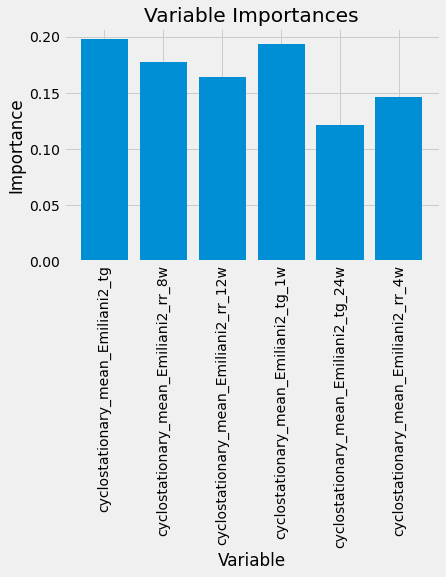

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

### Feed Forward

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

ffnn_val = feed_forward(4)

hist_val = ffnn_val.fit(scaled_train_features.values, scaled_train_target.values.ravel(), shuffle=False, epochs=1000, 
                       validation_data=(scaled_valid_features.values, scaled_valid_target.values.ravel()),  verbose = 0)

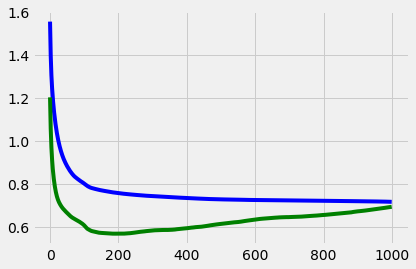

In [ ]:
plt.plot(hist_val.history['loss'], 'b')
plt.plot(hist_val.history['val_loss'],'g')

In [32]:
ffnn = feed_forward(4)
ffnn.fit(train_valid_features.values, train_valid_target.values.ravel(), shuffle=False, epochs=150, verbose = 0)

In [ ]:
ffnn.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 4)                 28        
                                                                 
 dense_39 (Dense)            (None, 1)                 5         
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [33]:
ffnn_MAE = mean_absolute_error(scaled_test_target.values.ravel(), ffnn.predict(scaled_test_features.values))
ffnn_MSE = mean_squared_error(scaled_test_target.values.ravel(), ffnn.predict(scaled_test_features.values))

metric = RSquare()
metric.update_state(scaled_test_target.values, ffnn.predict(scaled_test_features.values))
r2_test = metric.result()
r2_test.numpy()

metric = RSquare()
metric.update_state(train_valid_target.values, ffnn.predict(train_valid_features.values))
r2_train = metric.result()
r2_train.numpy()

25/25 [==============================] - 0s 1ms/step


0.26118028

In [34]:
print(" FFNN: ")
print(" MAE: ", round(ffnn_MAE,3), "\n", "MSE: ", round(ffnn_MSE,3), "\n","R2_test: ",
      round(r2_test.numpy(),3), "\n", "R2_train: ", round(r2_train.numpy(),3))

 FFNN: 
 MAE:  0.745 
 MSE:  0.842 
 R2_test:  0.131 
 R2_train:  0.261


#Graphs

In [ ]:
X_train = X_train_all.iloc[:,[0, 10, 11, 2, 7, 9]]
X_test = X_test_all.iloc[:,[0, 10, 11, 2, 7, 9]]
reg = LinearRegression().fit(X_train, y_train_regr)

7/7 [==============================] - 0s 2ms/step


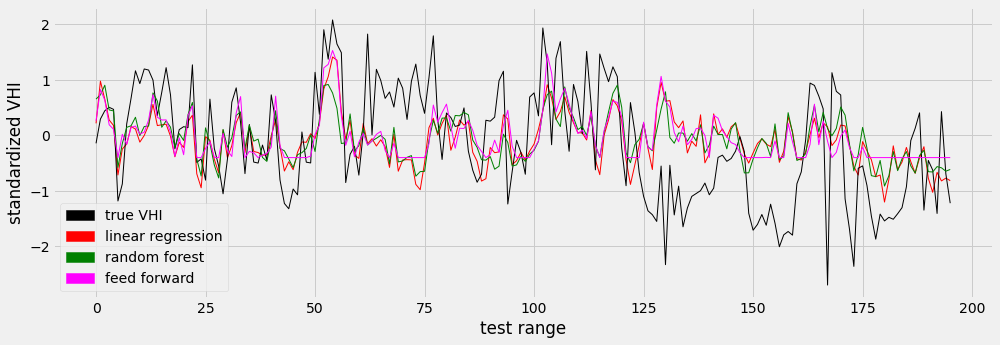

In [ ]:
import matplotlib.patches as mpatches

prediction = reg.predict(X_test)

plt.plot(prediction, color='red')
y_test.reset_index(drop = True, inplace = True)
plt.plot(y_test, color='black')
random_forest = rfc.predict(scaled_test_features.values)
plt.plot(random_forest, color='green')
ffnn_pred = ffnn.predict(scaled_test_features.values)
plt.plot(ffnn_pred, color='magenta')

plt.xlabel("test range")
plt.ylabel("standardized VHI")

black_patch = mpatches.Patch(color='black', label='true VHI')
red_patch = mpatches.Patch(color='red', label='linear regression')
green_patch = mpatches.Patch(color='green', label='random forest')
magenta_patch = mpatches.Patch(color='magenta', label='feed forward')

plt.legend(handles=[black_patch, red_patch,green_patch, magenta_patch])

plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['lines.linewidth'] = 1
plt.show()

25/25 [==============================] - 0s 2ms/step


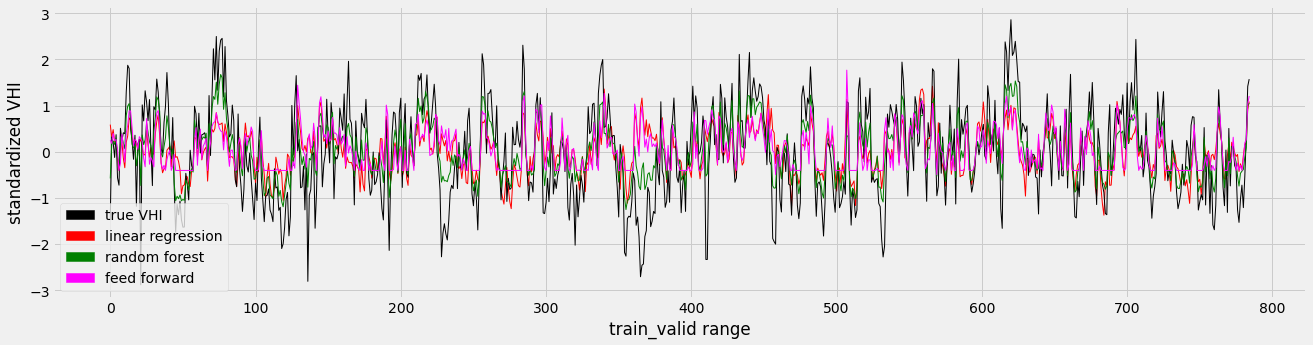

In [ ]:
prediction = reg.predict(X_train)
plt.plot(prediction, color='red')
y_train_regr.reset_index(drop = True, inplace = True)
plt.plot(y_train_regr, color='black')
random_forest = rfc.predict(train_valid_features.values)
plt.plot(random_forest, color='green')
ffnn_pred = ffnn.predict(train_valid_features.values)
plt.plot(ffnn_pred, color='magenta')

plt.xlabel("train_valid range")
plt.ylabel("standardized VHI")

black_patch = mpatches.Patch(color='black', label='true VHI')
red_patch = mpatches.Patch(color='red', label='linear regression')
green_patch = mpatches.Patch(color='green', label='random forest')
magenta_patch = mpatches.Patch(color='magenta', label='feed forward')

plt.legend(handles=[black_patch, red_patch,green_patch, magenta_patch])
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['lines.linewidth'] = 1
plt.show()

# results

#### **All the features:**     
regression: R2: 0.0319, MAE: 0.804     
extra tree regressor: R2 0.0559, MAE 0.793  
FFNN: R2 0.0265, MAE 0.786  
#### **Chosen features without aggregation:**
best group of features found (3/20):  
3: Piemonte_Sud_tg  
12: Emiliani1_rr   
1: Dora_tg  
regression:  R2: 0.0721, MAE: 0.789    
extra tree regressor: R2 0.0558, MAE 0.794     
FFNN: R2 0.06, MAE 0.784        
#### **Chosen features with aggregation:**
best group of features found (4/140):  
93: Emiliani1_rr_4w,  
68: Lambro_Olona_tg_1w,  
131: Lambro_Olona_rr_12w,   
110: Oglio_Iseo_rr_1w,    
regression:  R2_train: 0.237, R2_test: 0.13, MAE: 0.74  
extra tree regressor: R2_train: 0.7185, R2_test: 0.174, MAE: 0.739   
FFNN: R2_train: 0.313, R2_test: 0.136, MAE: 0.756  
#### **All features with aggreg only of target (Emi2)**  
regression:  R2_train:  0.2355, R2_test:  0.1074, MAE:  0.7668  
extra tree regressor: R2_train: 0.83, R2_test  0.197, MAE: 0.7288  
FFNN: R2_train: 0.32, R2_test: 0.13, MAE: 0.75  
#### **Chosen features, aggreg, only of target (Emi2)** 
best group of features found (6/20):  
0: Emiliani2_tg  
10: Emiliani2_rr_8w  
11: Emiliani2_rr_12w  
2: Emiliani2_tg_1w  
7: Emiliani2_tg_24w  
9: Emiliani2_rr_4w  
regression: R2_train: 0.2258, R2_test: 0.113, MAE: 0.766  
extra tree regressor: R2_train: 0.71, R2_test: 0.13, MAE: 0.74  
FFNN: R2_train: 0.23, R2_test: 0.16, MAE: 0.74    
#### **Chosen features, aggreg, classification:** 
93: Emiliani1_rr_4w, importance in random forest: 0.29  
68: Lambro_Olona_tg_1w, imp: 0.27  
131: Lambro_Olona_rr_12w, imp: 0.26  
110: Oglio_Iseo_rr_1w, imp: 0.18  
extra tree classifier: acc_test: 0.4643 acc_train: 0.959 MAE: 0.622  
FFNN: acc_test: 0.43 acc_train: 0.52 MAE: 0.408